# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para ``Epilepsy`` a ser clasificado con la codificación ``Tendencia`` sobre RF.

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
EPILEPSY_PATH = "data/epilepsy"

DATA_TO_SAVE = "Epilepsy"

PKL_DIR = "pkl/RF/Epilepsy/"
PKL_NAME = "epilepsy_RF_trend.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_epilepsy_dataset

train, test = import_epilepsy_dataset(EPILEPSY_PATH)

In [4]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [5]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [6]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 137
Train: Actual number of series: 137
Test: Previous number of series: 138
Test: Actual number of series: 138


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [7]:
# Nothing to see here

# <font color=#cd0000> División en ventanas </font>
- Como concluimos en el análisis en profundidad no aplicaremos enventanado pues las series son muy cortas y, aplicar un enventanado que divida las series en subseries, daría como resultado series mucho más cortas de las que sería más difícil extraer patrones en el caso de clases como ``epilepsy``, por ejemplo.

In [8]:
# Nothing to see here

## <font color=#cd0000> Codificación </font>
- Series originales (no aplicamos ninguna codificación extra)

In [9]:
from utils.codifications import temporal_trend_fn

train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])


# <font color=#cd0000> Preparación de los datos </font>

In [10]:
X_train = train.derived_data.drop(['id', 'class'], axis=1)
X_test = test.derived_data.drop(['id', 'class'], axis=1)

y_train = train.derived_data['class'].to_numpy()
y_test = test.derived_data['class'].to_numpy()

## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [11]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {'epilepsy': class_weights[0], 'running': class_weights[1],
                 'sawing': class_weights[2], 'walking': class_weights[3]}


# <font color=#cd0000> Diseño de la topología del bosque </font>
- Número de estimadores inicial recomendado
- Profundidad máxima recomendada

## <font color=#cd0000> Entrenamiento </font>

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=SEED,
    class_weight=class_weights
)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={'epilepsy': 1.0073529411764706,
                                     'running': 0.9513888888888888,
                                     'sawing': 1.1416666666666666,
                                     'walking': 0.9256756756756757},
                       max_depth=100, random_state=1)

## <font color=#cd0000> Clasificación </font>

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = np.asarray(y_test)
    
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[5290  585  552  543]
 [ 555 6099  498  433]
 [ 316  450 5129  255]
 [ 502  352  273 6458]]
              precision    recall  f1-score   support

    epilepsy       0.79      0.76      0.78      6970
     running       0.81      0.80      0.81      7585
      sawing       0.79      0.83      0.81      6150
     walking       0.84      0.85      0.85      7585

    accuracy                           0.81     28290
   macro avg       0.81      0.81      0.81     28290
weighted avg       0.81      0.81      0.81     28290



## <font color=#cd0000> Discusión de los resultados </font>
- Vamos a estudiar diferentes rangos de hiper-parámetros interesantes que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para un `n_estimators` pequeño (10) y una `max_depth` pequeña (10) observamos resultados bastante mejores en comparacióncon el clasificador RF sobre las series en bruto:
    ```
    Confusion matrix:
    [[4983  588  751  648]
     [ 727 5676  630  552]
     [ 376  360 5093  321]
     [ 468  331  410 6376]]

    Classification report:
                     precision    recall  f1-score   support

        epilepsy       0.76      0.71      0.74      6970
         running       0.82      0.75      0.78      7585
          sawing       0.74      0.83      0.78      6150
         walking       0.81      0.84      0.82      7585

        accuracy                           0.78     28290
       macro avg       0.78      0.78      0.78     28290
    weighted avg       0.78      0.78      0.78     28290
    ```
  - Para un `n_estimators` pequeño (10) y una `max_depth` grande (200) observamos resultados ligeramente mejores en la clasificación de todas las clases:
    ```
    Confusion matrix:
    [[5274  616  565  515]
     [ 738 5923  487  437]
     [ 441  505 4943  261]
     [ 585  433  310 6257]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.75      0.76      0.75      6970
         running       0.79      0.78      0.79      7585
          sawing       0.78      0.80      0.79      6150
         walking       0.84      0.82      0.83      7585

        accuracy                           0.79     28290
       macro avg       0.79      0.79      0.79     28290
    weighted avg       0.79      0.79      0.79     28290
    ```
  - Para un `n_estimators` pequeño (10) y una `max_depth` intermedia (100) observamos resultados análogos a los anteriores, ahora probaremos a modificar `n_estimators` manteniendo el valor actual de `max_depth`:
    ```
    Confusion matrix:
    [[5274  616  565  515]
     [ 738 5923  487  437]
     [ 441  505 4943  261]
     [ 585  433  310 6257]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.75      0.76      0.75      6970
         running       0.79      0.78      0.79      7585
          sawing       0.78      0.80      0.79      6150
         walking       0.84      0.82      0.83      7585

        accuracy                           0.79     28290
       macro avg       0.79      0.79      0.79     28290
    weighted avg       0.79      0.79      0.79     28290
    ```
  - Para un `n_estimators` grande (200) y una `max_depth` intermedia (100) observamos resultados mejores que los obtenidos hasta ahora, probaremos con un `n_estimators` intermedio más adelante:
    ```
    Confusion matrix:
    [[5283  586  558  543]
     [ 536 6124  495  430]
     [ 288  436 5164  262]
     [ 508  360  277 6440]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.80      0.76      0.78      6970
         running       0.82      0.81      0.81      7585
          sawing       0.80      0.84      0.82      6150
         walking       0.84      0.85      0.84      7585

        accuracy                           0.81     28290
       macro avg       0.81      0.81      0.81     28290
    weighted avg       0.81      0.81      0.81     28290
    ```


  - Para un `n_estimators` intermedio (100) y una `max_depth` intermedia (100) observamos resultados algo peores (muy sutilmente) en comparación con los anteriores en lo que a la `precision` de cada clase se refiere:
    ```
    Confusion matrix:
    [[5290  585  552  543]
     [ 555 6099  498  433]
     [ 316  450 5129  255]
     [ 502  352  273 6458]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.79      0.76      0.78      6970
         running       0.81      0.80      0.81      7585
          sawing       0.79      0.83      0.81      6150
         walking       0.84      0.85      0.85      7585

        accuracy                           0.81     28290
       macro avg       0.81      0.81      0.81     28290
    weighted avg       0.81      0.81      0.81     28290
    ```

## <font color=#cd0000> Conclusiones </font>
- Observamos que, la puntuación del clasificador, mejora significativamente con la codificación actual lo que tiene bastante sentido porque nos hemos ocupado de caracterizar la velocidad de cambio de las series que era, precisamente, lo que diferenciaba a unas de otras.
- Lo que es curioso es que clasifique tan bien secuencias ordenadas un clasificador que no tiene en cuenta el orden secuencial de los datos.
  - No obstante, es posible que clasifique de este modo ya que, la codificación de la tendencia contiene información con respecto a la siguiente muestra lo que, intuitivamente, significa que estamos brindando información al clasificador con respecto a la muestra actual y con respecto a la siguiente.
  - Solo basta con que un conjunto de datos tenga frecuencias muy altas como para notar lo significativa que es esta codificación, de nuevo recordemos:
    - Series lentas (diferencias pequeñas entre muestras) -> Actividades de baja intensidad (`walking`)
    - Series rápidas (diferencias grandes entre muestras) -> Actividades de alta intensidad (`running` y `sawing`)
    - Evolución no coordinada entre atributos de una misma muestra -> `epilepsy`
- El rango de optimización de hiper-parámetros será:
  - `n_estimators`: [100, 200]
  - `max_depth`: [100, 200]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con RF maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [14]:
N_ESTIMATORS_RANGE = range(100, 200)
MAX_DEPTH_RANGE = range(100, 200)


In [15]:
import random
import pickle
import utils.constants as cs
from sklearn.ensemble import RandomForestClassifier
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict


def rf_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        class_weights,
        cv=5):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    n_estimators_list = random.sample(list(N_ESTIMATORS_RANGE), n_samples)
    max_depth_list = random.sample(list(MAX_DEPTH_RANGE), n_samples)

    best_hyp_params = None
    best_score = 0
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=SEED,
                class_weight=class_weights
            )

            reports = windowed_cross_val(
                clf,
                windowed_series,
                relation_with_series,
                estimator_type=cs.ESTIMATOR_SKLEARN,
                cv=cv,
                drop_columns=['id', 'class'],
                seed=SEED
            )
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(n_estimators, max_depth)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (n_estimators, max_depth)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: N_Estimators={}; Max_Depth={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: N_Estimators={}; Max_Depth={}--------------"
                  .format(n_estimators, max_depth))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [16]:
rf_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    class_weights,
    cv=5)


		--------------ACTUAL BEST: N_Estimators=132; Max_Depth=149--------------
Accuracy: 0.8085537177210853 +/- 0.029925025396569153
epilepsy:
	precision: 0.7547387883784598 +/- 0.09245875642541755
	recall: 0.7589043747580333 +/- 0.04539993936809427
	f1-score: 0.7521468397569561 +/- 0.04586199119970057
	support: 1394.0 +/- 328.0
running:
	precision: 0.8085405610337476 +/- 0.03363086116492928
	recall: 0.7842682926829269 +/- 0.034822145203155894
	f1-score: 0.7949016349518365 +/- 0.012097658957896528
	support: 1476.0 +/- 239.06902768865731
sawing:
	precision: 0.8168797110341532 +/- 0.07267778651392784
	recall: 0.8448037166085947 +/- 0.013937238869464125
	f1-score: 0.8293970534684348 +/- 0.044335070251907936
	support: 1230.0 +/- 129.65338406690356
walking:
	precision: 0.8273493303997095 +/- 0.09769971291647862
	recall: 0.8472899728997291 +/- 0.05427449155817219
	f1-score: 0.8338754677825827 +/- 0.063906451326363
	support: 1517.0 +/- 422.120835780467
macro avg:
	precision: 0.8018770977115175 +/

((132, 188),
 {'accuracy': (0.8085537177210853, 0.029925025396569153),
  'epilepsy': {'precision': (0.7547387883784598, 0.09245875642541755),
   'recall': (0.7589043747580333, 0.04539993936809427),
   'f1-score': (0.7521468397569561, 0.04586199119970057),
   'support': (1394.0, 328.0)},
  'running': {'precision': (0.8085405610337476, 0.03363086116492928),
   'recall': (0.7842682926829269, 0.034822145203155894),
   'f1-score': (0.7949016349518365, 0.012097658957896528),
   'support': (1476.0, 239.06902768865731)},
  'sawing': {'precision': (0.8168797110341532, 0.07267778651392784),
   'recall': (0.8448037166085947, 0.013937238869464125),
   'f1-score': (0.8293970534684348, 0.044335070251907936),
   'support': (1230.0, 129.65338406690356)},
  'walking': {'precision': (0.8273493303997095, 0.09769971291647862),
   'recall': (0.8472899728997291, 0.05427449155817219),
   'f1-score': (0.8338754677825827, 0.063906451326363),
   'support': (1517.0, 422.120835780467)},
  'macro avg': {'precision

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- No llevaremos a cabo esta aproximación ya que tenemos datos suficientes como para ejecutar validación cruzada.

In [17]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_estimators`` = 132 y ``max_depth`` = 188:
    ```
        Accuracy: 0.8085537177210853 +/- 0.029925025396569153
        epilepsy:
            precision: 0.7547387883784598 +/- 0.09245875642541755
            recall: 0.7589043747580333 +/- 0.04539993936809427
            f1-score: 0.7521468397569561 +/- 0.04586199119970057
            support: 1394.0 +/- 328.0
        running:
            precision: 0.8085405610337476 +/- 0.03363086116492928
            recall: 0.7842682926829269 +/- 0.034822145203155894
            f1-score: 0.7949016349518365 +/- 0.012097658957896528
            support: 1476.0 +/- 239.06902768865731
        sawing:
            precision: 0.8168797110341532 +/- 0.07267778651392784
            recall: 0.8448037166085947 +/- 0.013937238869464125
            f1-score: 0.8293970534684348 +/- 0.044335070251907936
            support: 1230.0 +/- 129.65338406690356
        walking:
            precision: 0.8273493303997095 +/- 0.09769971291647862
            recall: 0.8472899728997291 +/- 0.05427449155817219
            f1-score: 0.8338754677825827 +/- 0.063906451326363
            support: 1517.0 +/- 422.120835780467
        macro avg:
            precision: 0.8018770977115175 +/- 0.026404748071868694
            recall: 0.808816589237321 +/- 0.02478864345688691
            f1-score: 0.8025802489899526 +/- 0.026411852180868833
            support: 5617.0 +/- 164.0
        weighted avg:
            precision: 0.8156201394431568 +/- 0.029090409174834127
            recall: 0.8085537177210853 +/- 0.029925025396569153
            f1-score: 0.8096174303405522 +/- 0.030443039771998543
            support: 5617.0 +/- 164.0
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [18]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


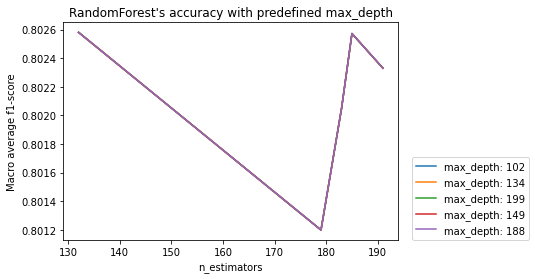

In [19]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


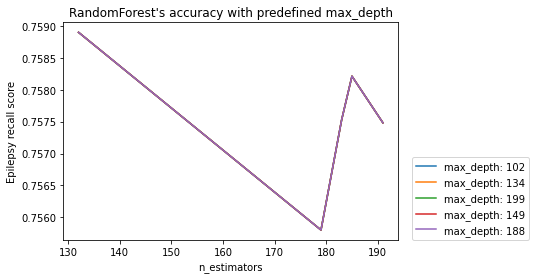

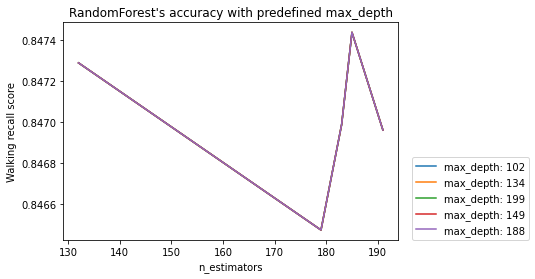

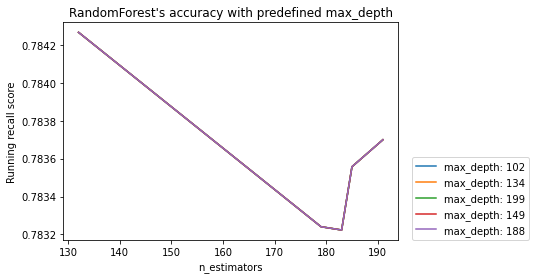

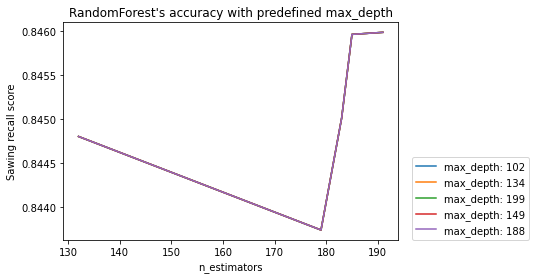

In [20]:
epilepsy_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['epilepsy']['recall'][0],
                   'std': all_reports[z]['epilepsy']['recall'][1]}),
    all_reports
))

walking_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['walking']['recall'][0],
                   'std': all_reports[z]['walking']['recall'][1]}),
    all_reports
))

running_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['running']['recall'][0],
                   'std': all_reports[z]['running']['recall'][1]}),
    all_reports
))

sawing_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['sawing']['recall'][0],
                   'std': all_reports[z]['sawing']['recall'][1]}),
    all_reports
))

plot_score(
    [epilepsy_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Epilepsy recall score'
)

plot_score(
    [walking_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Walking recall score'
)

plot_score(
    [running_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Running recall score'
)

plot_score(
    [sawing_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Sawing recall score'
)


## <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

### <font color=#cd0000> Entrenamiento </font>

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=132,
    max_depth=188,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight={'epilepsy': 1.0073529411764706,
                                     'running': 0.9513888888888888,
                                     'sawing': 1.1416666666666666,
                                     'walking': 0.9256756756756757},
                       max_depth=188, n_estimators=132, random_state=1)

### <font color=#cd0000> Clasificación </font>

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = np.asarray(y_test)
    
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[5267  597  562  544]
 [ 537 6124  490  434]
 [ 302  441 5144  263]
 [ 511  357  279 6438]]
              precision    recall  f1-score   support

    epilepsy       0.80      0.76      0.78      6970
     running       0.81      0.81      0.81      7585
      sawing       0.79      0.84      0.81      6150
     walking       0.84      0.85      0.84      7585

    accuracy                           0.81     28290
   macro avg       0.81      0.81      0.81     28290
weighted avg       0.81      0.81      0.81     28290



# <font color=#cd0000> Conclusiones </font>
- Al parecer ya hemos alcanzado el pico de rendimiento de este clasificador y, como mencionábamos, es posible que tenga tan buen desempeño porque la codificación de la tendencia contiene información con respecto a la siguiente muestra lo que, intuitivamente, significa que estamos brindando información al clasificador con respecto a la muestra actual y con respecto a la siguiente.
  - Si tenemos en cuenta lo anterior y que este conjunto de datos tiene una división clara de sus clases en función de su velocidad de cambio, podemos entender por qué se desenvuelve tan bien:
    - Series lentas (diferencias pequeñas entre muestras) -> Actividades de baja intensidad (`walking`)
    - Series rápidas (diferencias grandes entre muestras) -> Actividades de alta intensidad (`running` y `sawing`)
    - Evolución no coordinada entre atributos de una misma muestra -> `epilepsy`